# <center>**Simulation and Monte Carlo Methods (ENSAE)**</center> 

For our Monte Carlo class , we reproduce the simulation experiments of the paper ["*On Multilevel Monte Carlo Unbiased Gradient Estimation for Deep Latent Variable Models*"](https://proceedings.mlr.press/v130/shi21d.html) written by Yuyang Shi and Rob Cornish in 2021. We limit ourselves to the Linear Gaussian framework to quantify the bias and the variance of the computed estimators.



---



---



In [95]:
import numpy as np
from scipy.stats import multivariate_normal
from scipy.special import logsumexp
import matplotlib.pyplot as plt
import random

# <center>**PART 1 : LIKELIHOOD ESTIMATORS**</center> 

---



# **1) DATA GENERATING PROCESS**

On tire un échantillon i.i.d. de $z_i$ de densité $q_{\phi}(.|x)$. Dans notre application on définit $q_{\phi}(.|x)$ comme une loi normale multivariée de moyenne nulle et de matrice de variance-covariance $2/3*I$. Nous ne considérons pas dans notre application de perturbations additionnelles sur cette distribution. Ainsi, ${\phi} = (I,0)$.

In [96]:
def generate_z(K,x_data):
    z = []
    for i in range(2**(K+1)):
        z.append(np.random.multivariate_normal(x_data, (2/3)*np.identity(20)))
    z_O = z[1::2]
    z_E = z[::2]
    return z, z_O, z_E

On doit maintenant tirer $q_{\phi}(z|x)$ et la loi jointe $p_{\theta}(x,z)$. Conformément à la procédure décrite dans l'article on tire $q_{\phi}(z|x)$ comme une loi normale de

In [97]:
def generate_q_p(K,mean,x_data,z,z_O,z_E):
    q,p = [],[]
    for i in range(2**(K+1)):
        q.append(multivariate_normal.pdf(z[i], mean=x_data, cov=(2/3)*np.identity(20)))
        p.append(multivariate_normal.pdf(z[i], mean=mean, cov=np.identity(20))*multivariate_normal.pdf(x_data, mean=z[i], cov=np.identity(20)))
    return q, p

In [98]:
theta = np.random.normal(0,1)
print("Theta = " + str('{:.2f}'.format((theta))))
x_data = np.random.multivariate_normal(np.zeros(20)+theta, 2*np.identity(20))

Theta = -1.19


# **2) THEORETICAL LIKELIHOOD**

In [99]:
def true_likelihood(x_data,theta):
  cte = (2*np.pi)**(-len(x_data)/2)*1/(np.sqrt(np.linalg.det(2*np.identity(20))))
  somme = 0
  for i in range(len(x_data)):
    somme += (x_data[i] - theta)**2
  return cte*np.exp(-somme/4)

# **3) SS ESTIMATOR**

### **a) Estimation function**

In [100]:
def SS_estimator(n_sim, mean, r, x_data):
    ss = []
    for i in range(n_sim):
        K = np.random.geometric(r)
        z, z_O, z_E = generate_z(K,x_data)
        q, p = generate_q_p(K,mean,x_data,z,z_O,z_E)
        w = np.log(p) - np.log(q)
        w_O = w[1::2]
        w_E = w[::2]
            
        I0 = w.mean()

        l_O = logsumexp(w_O) - np.log(len(w_O))    

        l_E = logsumexp(w_E) - np.log(len(w_E))    

        L_O_E = logsumexp(w) - np.log(len(w))
    
        DeltaK = L_O_E - 0.5*(l_O + l_E)
    
        ml_ll_ss = I0 + (DeltaK/(r*(1-r)**(K-1)))
        
        ss.append(ml_ll_ss)
    mean_value = np.mean(ss)
    #std_error_value = np.std(ss) / np.sqrt(len(ss))

    return mean_value

### **b) Plotting function**

In [101]:
def plot_ss(debut,fin,pas,n_sim,x_data):
  liste = np.linspace(debut,fin,pas)
  progress = [round(pas/4),round(pas/2),round((3*pas)/4)]
  x,y = [],[]
  for k in liste:
    y.append(SS_estimator(n_sim=n_sim, mean=np.zeros(20)+k, r=0.6, x_data=x_data))
    x.append(k)
    if len(y) in progress:
      print("Progress SS: "+str('{:.1f}'.format(100*(len(y)/pas)))+"%")              
  return x, y

In [102]:
print("Theta = " + str('{:.2f}'.format((theta))))
x_ss, y_ss = plot_ss(debut=-4, fin=4, pas=40, n_sim=400, x_data=x_data)

Theta = -1.19
Progress SS: 25.0%
Progress SS: 50.0%
Progress SS: 75.0%


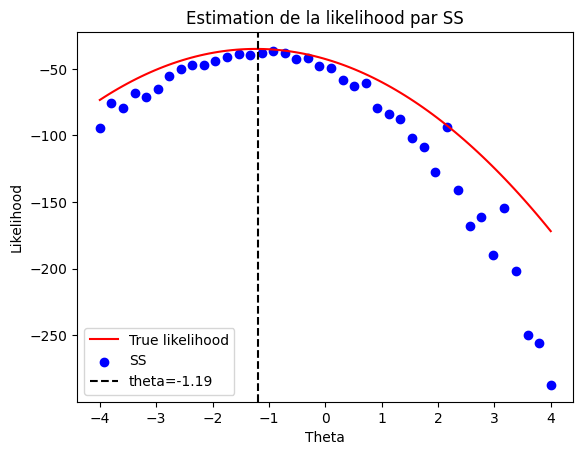

In [103]:
theta_range = np.linspace(-4, 4, 100)  
likelihood_values = [np.log(true_likelihood(x_data, theta)) for theta in theta_range]  

plt.plot(theta_range, likelihood_values, color='r', label='True likelihood')  
plt.scatter(x_ss,y_ss, color='b', label='SS')
plt.axvline(x=theta, color='black', linestyle='--', label='theta='+ str('{:.2f}'.format(theta)))
plt.xlabel('Theta')
plt.ylabel('Likelihood')
plt.title('Estimation de la likelihood par SS')
plt.legend(loc='best')
plt.show()  

# **4) RUSSIAN ROULETTE ESTIMATOR**

### **a) Estimation function**

In [104]:
def delta_rr(w, w_O, w_E, K):
  delta = []
  sum = 0
  for k in range(K+1):
    w_k = w[:2**k]
    w_k = np.append(w_k, w[2**K:2**K + 2**k])
    value = (logsumexp(w_k) - np.log(len(w_k))) - 0.5*((logsumexp(w_O[:2**k]) - np.log(len(w_O[:2**k]))) + (logsumexp(w_E[:2**k]) - np.log(len(w_E[:2**k]))))
    delta.append(value)
  return delta 

In [105]:
def RR_estimator(n_sim, mean, r, x_data):
    rr = []
    for i in range(n_sim):
        sum_rr = 0
        K = np.random.geometric(r)
        z, z_O, z_E = generate_z(K,x_data)
        q, p = generate_q_p(K,mean,x_data,z,z_O,z_E)
        w = np.log(p) - np.log(q)
        w_O = w[1::2]
        w_E = w[::2]  

        I0 = w.mean()
        
        proba_value = [1]
        for i in range(1,K+1):
          proba_value.append((1-r)**(i-1))

        value_somme = [delta_rr(w, w_O, w_E, K)[i]/proba_value[i] for i in range(K+1)]

        sum_rr = sum(value_somme)
            
        ml_ll_rr = I0 + sum_rr
        rr.append(ml_ll_rr)
        
    mean_value = np.mean(rr)
    #std_error_value = np.std(rr) / np.sqrt(len(rr))

    return mean_value

### **b) Plotting function**

In [106]:
def plot_rr(debut,fin,pas,n_sim,x_data):
  liste = np.linspace(debut,fin,pas)
  progress = [round(pas/4),round(pas/2),round((3*pas)/4)]
  x,y = [],[]
  for k in liste:
    y.append(RR_estimator(n_sim=n_sim, mean=np.zeros(20)+k, r=0.6, x_data=x_data))
    x.append(k)
    if len(y) in progress:
      print("Progress RR: "+str('{:.1f}'.format(100*(len(y)/pas)))+"%")
  return x, y

In [107]:
print("Theta = " + str('{:.2f}'.format((theta))))
x_rr, y_rr = plot_rr(debut=-4, fin=4, pas=40, n_sim=400, x_data=x_data)

Theta = -1.19
Progress RR: 25.0%
Progress RR: 50.0%
Progress RR: 75.0%


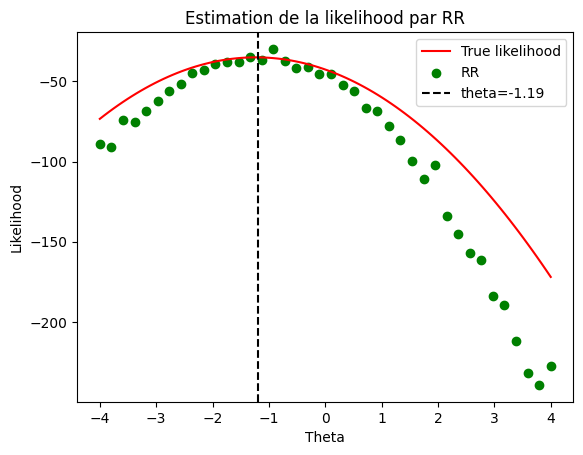

In [108]:
theta_range = np.linspace(-4, 4, 100)  
likelihood_values = [np.log(true_likelihood(x_data, theta)) for theta in theta_range]  

plt.plot(theta_range, likelihood_values, color='r', label='True likelihood')  
plt.scatter(x_rr,y_rr, color='g', label='RR')
plt.axvline(x=theta, color='black', linestyle='--', label='theta='+ str('{:.2f}'.format(theta)))
plt.xlabel('Theta')
plt.ylabel('Likelihood')
plt.title('Estimation de la likelihood par RR')
plt.legend(loc='best')
plt.show()  

# **5) IWAE ESTIMATOR**

### **a) Estimation function**

In [109]:
def sum_w(k,w):
    sum_w=0
    for i in range(k):
        sum_w += np.exp(w[i])
    return sum_w

In [110]:
def iwae(n_sim,k,mean,x_data):
    iwae=[]
    for i in range(n_sim):
        log_sum=0
        z, z_O, z_E = generate_z(k,x_data)
        q, p = generate_q_p(k,mean,x_data,z,z_O,z_E)
        w = np.log(p) - np.log(q)
        log_sum = np.log(sum_w(k,w))-np.log(k)
        iwae.append(log_sum)
    return np.mean(iwae)

### **b) Plotting function**

In [111]:
def plot_iwae(debut, fin, pas, n_sim, x_data):
  liste = np.linspace(debut,fin,pas)
  progress = [round(pas/4),round(pas/2),round((3*pas)/4)]
  x,y = [],[]
  for k in liste:
    y.append(iwae(n_sim=n_sim, k=5, mean=np.zeros(20)+k, x_data=x_data))
    x.append(k)
    if len(y) in progress:
      print("Progress IWAE: "+str('{:.1f}'.format(100*(len(y)/pas)))+"%")
  return x, y

In [112]:
print("Theta = " + str('{:.2f}'.format((theta))))
x_iwae, y_iwae = plot_iwae(debut=-4, fin=4, pas=40, n_sim=400, x_data=x_data)

Theta = -1.19
Progress IWAE: 25.0%
Progress IWAE: 50.0%
Progress IWAE: 75.0%


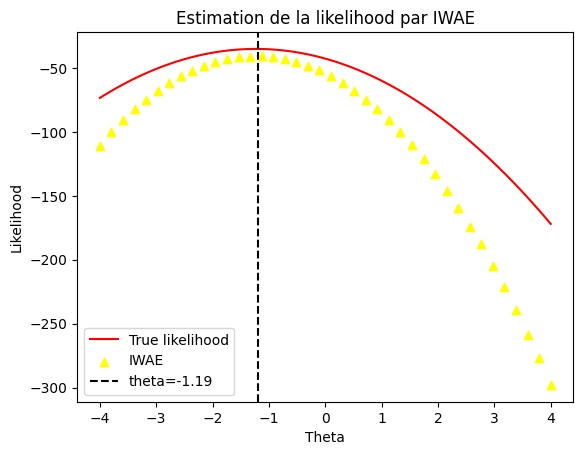

In [113]:
theta_range = np.linspace(-4, 4, 100)  
likelihood_values = [np.log(true_likelihood(x_data, theta)) for theta in theta_range]  

plt.plot(theta_range, likelihood_values, color='r', label='True likelihood')  
plt.scatter(x_iwae,y_iwae, color='yellow', marker='^', label='IWAE')
plt.axvline(x=theta, color='black', linestyle='--', label='theta='+ str('{:.2f}'.format(theta)))
plt.xlabel('Theta')
plt.ylabel('Likelihood')
plt.title('Estimation de la likelihood par IWAE')
plt.legend(loc='best')
plt.show()  

# **6) SUMO ESTIMATOR**

### **a) Estimation function**

In [114]:
def delta_sumo(k, q, p):
    w_k2,w_k1=[],[]
    for i in range(k+1):
        w_k1.append(p[i]/q[i])
    for i in range(k+2):
        w_k2.append(p[i]/q[i])
    l_k1 = np.log(np.mean(w_k1))
    l_k2 = np.log(np.mean(w_k2))
    delta_sumo = l_k2-l_k1
    return delta_sumo

In [115]:
def sumo_estimator(n_sim, mean, r, x_data):
    sumo = []
    for i in range(n_sim):
        sum_sumo = 0
        K = np.random.geometric(r)
        z, z_O, z_E = generate_z(K,x_data)
        q, p = generate_q_p(K,mean,x_data,z,z_O,z_E)
        w = np.log(p) - np.log(q)
            
        I0 = w.mean()
        
        for j in range(1,K):
            sum_sumo += (delta_sumo(j,q,p)/((1-r)**j))
            
        ml_ll_sumo = I0 + sum_sumo
        sumo.append(ml_ll_sumo)
        
    mean_value = np.mean(sumo)
    #std_error_value = np.std(sumo) / np.sqrt(len(sumo))

    return mean_value

### **b) Plotting function**

In [116]:
def plot_sumo(debut,fin,pas,n_sim,x_data):
  liste = np.linspace(debut,fin,pas)
  progress = [round(pas/4),round(pas/2),round((3*pas)/4)]
  x,y = [],[]
  for k in liste:
    y.append(sumo_estimator(n_sim=300, mean=np.zeros(20)+k, r=0.6, x_data=x_data))
    x.append(k)
    if len(y) in progress:
      print("Progress SUMO: "+str('{:.1f}'.format(100*(len(y)/pas)))+"%")
  return x, y

In [117]:
print("Theta = " + str('{:.2f}'.format((theta))))
x_sumo, y_sumo = plot_sumo(debut=-4, fin=4, pas=40, n_sim=400, x_data=x_data)

Theta = -1.19
Progress SUMO: 25.0%
Progress SUMO: 50.0%
Progress SUMO: 75.0%


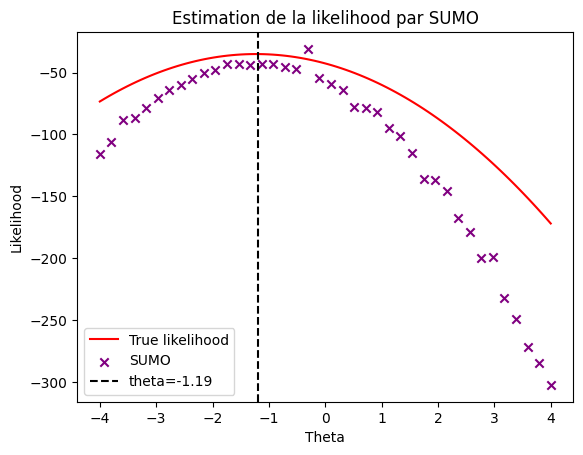

In [118]:
theta_range = np.linspace(-4, 4, 100)  
likelihood_values = [np.log(true_likelihood(x_data, theta)) for theta in theta_range]  

plt.plot(theta_range, likelihood_values, color='r', label='True likelihood')  
plt.scatter(x_sumo,y_sumo, color='purple', marker='x', label='SUMO')
plt.axvline(x=theta, color='black', linestyle='--', label='theta='+ str('{:.2f}'.format(theta)))
plt.xlabel('Theta')
plt.ylabel('Likelihood')
plt.title('Estimation de la likelihood par SUMO')
plt.legend(loc='best')
plt.show()  

# **All estimators on a single plot**

Theta = -1.19


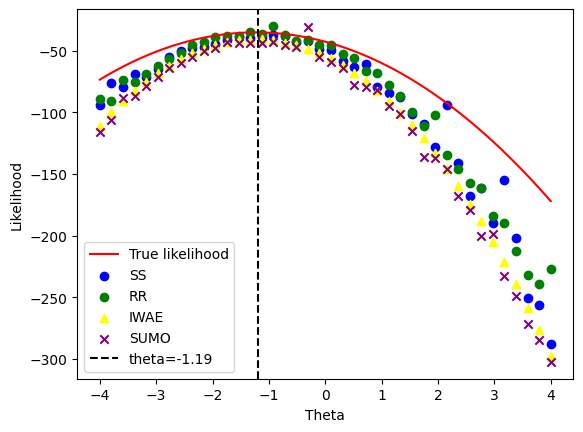

In [119]:
print("Theta = " + str('{:.2f}'.format((theta))))
theta_range = np.linspace(-4, 4, 100)  
likelihood_values = [np.log(true_likelihood(x_data, theta)) for theta in theta_range]  

plt.plot(theta_range, likelihood_values, color='r', label='True likelihood')
plt.scatter(x_ss,y_ss, color='b', label='SS')
plt.scatter(x_rr,y_rr, color='green', label='RR')
plt.scatter(x_iwae,y_iwae, color='yellow', marker='^', label='IWAE')
plt.scatter(x_sumo,y_sumo, color='purple', marker='x', label='SUMO')
plt.axvline(x=theta, color='black', linestyle='--', label='theta='+ str('{:.2f}'.format(theta)))
plt.xlabel('Theta')
plt.ylabel('Likelihood')
plt.legend(loc='best')
plt.show()  

# <center>**PART 2 : GRADIENT ESTIMATORS**</center>

---



# **1) THEORETICAL GRADIENT**

In [120]:
def true_gradient(x,theta):
  gradient = 10*(x.mean()-theta)
  return gradient

# **2) SS Estimator**

In [121]:
y_grad_ss = np.gradient(y_ss)

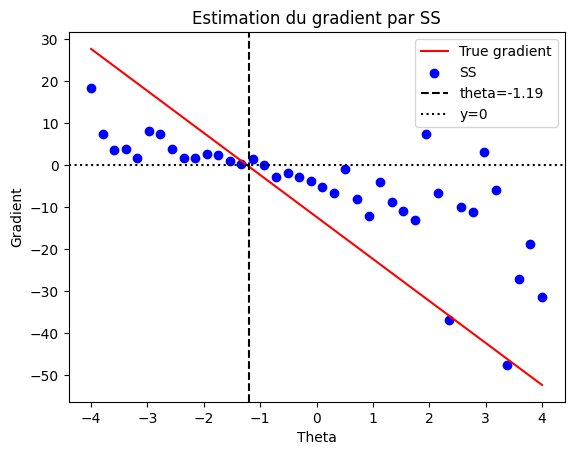

In [122]:
theta_range = np.linspace(-4, 4, 100)  
gradient_values = [true_gradient(x_data, theta) for theta in theta_range]  

plt.plot(theta_range, gradient_values, color='r', label='True gradient')  
plt.scatter(x_ss,y_grad_ss, color='b', label='SS')
plt.axvline(x=theta, color='black', linestyle='--', label='theta='+ str('{:.2f}'.format(theta)))
plt.axhline(y=0, color='black', linestyle=':', label='y=0')
plt.xlabel('Theta')
plt.ylabel('Gradient')
plt.title('Estimation du gradient par SS')
plt.legend(loc='best')
plt.show()  

# **3) RR ESTIMATOR**

In [123]:
y_grad_rr = np.gradient(y_rr)

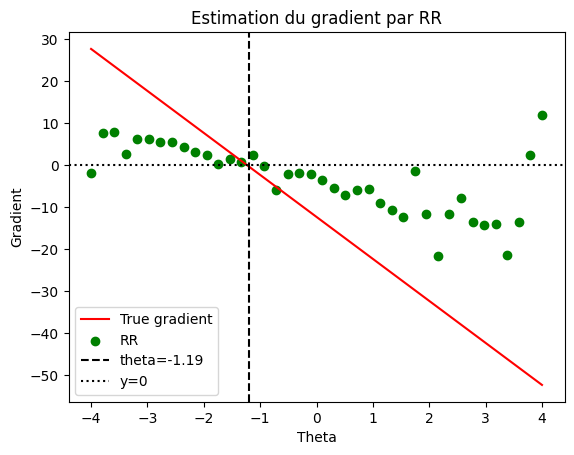

In [124]:
theta_range = np.linspace(-4, 4, 100)  
gradient_values = [true_gradient(x_data, theta) for theta in theta_range]  

plt.plot(theta_range, gradient_values, color='r', label='True gradient')  
plt.scatter(x_rr,y_grad_rr, color='g', label='RR')
plt.axvline(x=theta, color='black', linestyle='--', label='theta='+ str('{:.2f}'.format(theta)))
plt.axhline(y=0, color='black', linestyle=':', label='y=0')
plt.xlabel('Theta')
plt.ylabel('Gradient')
plt.title('Estimation du gradient par RR')
plt.legend(loc='best')
plt.show()  

# **4) IWAE ESTIMATOR**

In [125]:
y_grad_iwae = np.gradient(y_iwae)

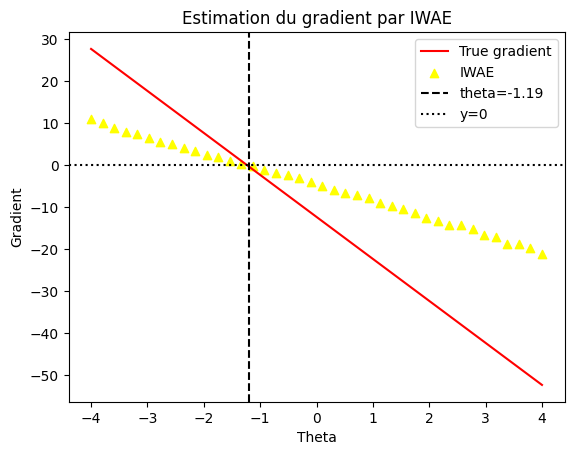

In [126]:
theta_range = np.linspace(-4, 4, 100)  
gradient_values = [true_gradient(x_data, theta) for theta in theta_range]  

plt.plot(theta_range, gradient_values, color='r', label='True gradient')  
plt.scatter(x_iwae,y_grad_iwae, color='yellow', marker='^', label='IWAE')
plt.axvline(x=theta, color='black', linestyle='--', label='theta='+ str('{:.2f}'.format(theta)))
plt.axhline(y=0, color='black', linestyle=':', label='y=0')
plt.xlabel('Theta')
plt.ylabel('Gradient')
plt.title('Estimation du gradient par IWAE')
plt.legend(loc='best')
plt.show()  

# **5) SUMO ESTIMATOR**

In [127]:
y_grad_sumo = np.gradient(y_sumo)

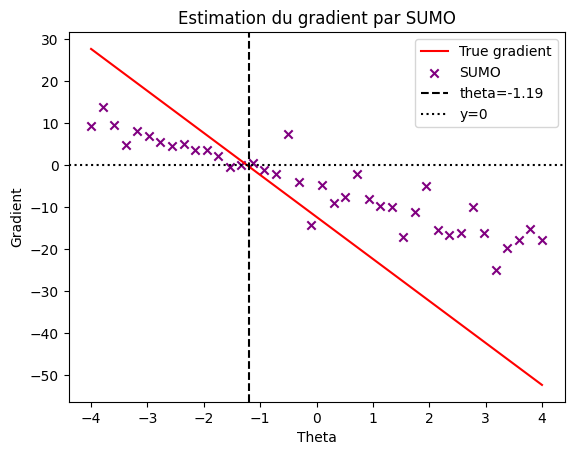

In [128]:
theta_range = np.linspace(-4, 4, 100)  
gradient_values = [true_gradient(x_data, theta) for theta in theta_range]  

plt.plot(theta_range, gradient_values, color='r', label='True gradient')  
plt.scatter(x_sumo,y_grad_sumo, color='purple', marker='x', label='SUMO')
plt.axvline(x=theta, color='black', linestyle='--', label='theta='+ str('{:.2f}'.format(theta)))
plt.axhline(y=0, color='black', linestyle=':', label='y=0')
plt.xlabel('Theta')
plt.ylabel('Gradient')
plt.title('Estimation du gradient par SUMO')
plt.legend(loc='best')
plt.show()  

# <center>**PART 3 : GRADIENT DESCENT**</center> 

---



In [129]:
def SGD(grad, alpha, num_iterations):
    theta_estimated = np.random.normal(0,1)
    for i in range(num_iterations):
        index = random.randint(0, len(grad) - 1)
        gradient_i = grad[index]
        theta_estimated = theta_estimated - alpha * gradient_i
    return print("Estimated theta = " + str('{:.2f}'.format((theta_estimated))))

In [130]:
print("Theta = " + str('{:.2f}'.format((theta))))
SGD(grad=y_grad_iwae, alpha=0.01, num_iterations=100)

Theta = -1.19
Estimated theta = 4.69
